In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import pyemma as pye
import glob
%matplotlib inline
import molpx 
%matplotlib ipympl
import matplotlib.pyplot as plt
%matplotlib ipympl
import matplotlib
import mdtraj
import nglview
matplotlib.__version__

_ColormakerRegistry()

'3.1.0'

In [2]:
path=os.path.join('/Volumes/Vikas\'s Drive','Trajectories_processed','POPC')
traj_files = glob.glob(path + "/*.xtc") 
pdb_files = glob.glob(path + "/*.pdb")
pdb_files

["/Volumes/Vikas's Drive/Trajectories_processed/POPC/604-639.pdb",
 "/Volumes/Vikas's Drive/Trajectories_processed/POPC/backbone.pdb",
 "/Volumes/Vikas's Drive/Trajectories_processed/POPC/combined_backbone.pdb",
 "/Volumes/Vikas's Drive/Trajectories_processed/POPC/processed-trans.pdb"]

## Feature Selection

In [3]:
feature = pye.coordinates.featurizer(pdb_files[1])
feature.add_selection(feature.select_Backbone())
reader = pye.coordinates.source(traj_files[-2], features=feature)

## Dimensionality Reduction

In [ ]:
tica_obj = pye.coordinates.tica(reader, dim=5, lag=1000)
Y =tica_obj.get_output()
Y_conc=np.concatenate(Y)

In [19]:
cumulative_variance=tica_obj.cumvar
with open('cumvar-50000.dat','w') as f:
    np.savetxt(f,cumulative_variance)

In [20]:
with open('TICA-backbone-dim-5-lag-50000.dat','w') as f:
    np.savetxt(f,Y_conc)
tica=Y_conc

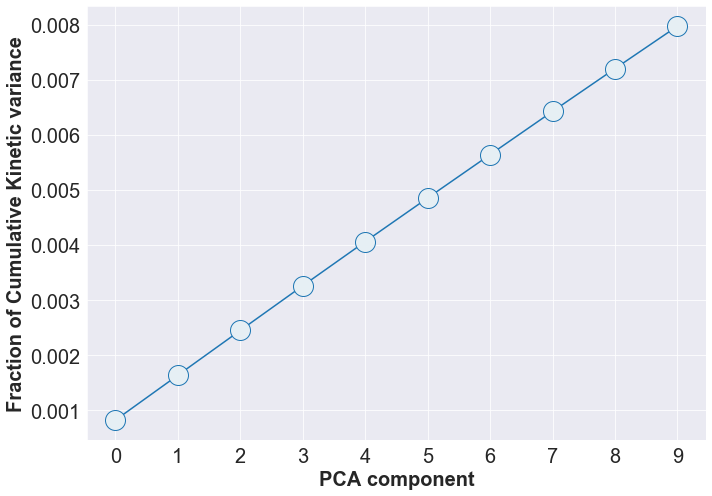

In [21]:
diverging_colors = sns.color_palette("RdBu", 10)
sns.set_style('darkgrid')
plt.figure(figsize=(10,7))
plt.plot(cumulative_variance[0:10], marker='o', ms=20, markerfacecolor=diverging_colors[5])
plt.xticks( np.arange(0,10), size=20)
plt.ylabel('Fraction of Cumulative Kinetic variance', size=20, weight='bold')
plt.yticks(size=20)
plt.xlabel('PCA component', size=20, weight='bold')
plt.tight_layout()
plt.savefig('cumulative variance.png',dpi=300)

## load saved tica object and data

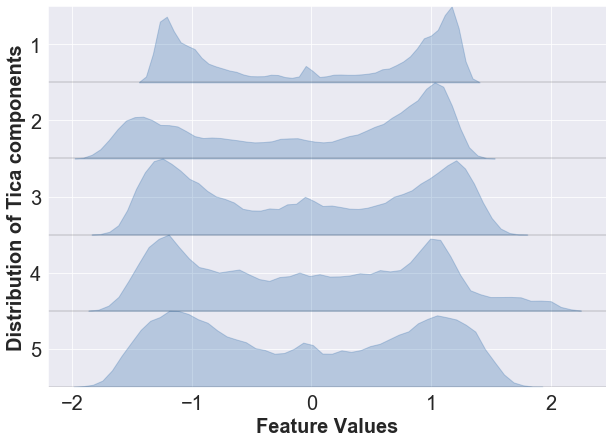

In [23]:
diverging_colors = sns.color_palette("RdBu", 10)
sns.set_style('darkgrid')
#pca_obj=np.genfromtxt('PCA-backbone-dim-5.dat')
fig, axes = plt.subplots(1, 1, figsize=(10, 7))
pye.plots.plot_feature_histograms(Y_conc, feature_labels=np.arange(1,6).tolist(), ax=axes,color=diverging_colors[9],)
plt.xticks(size=20)
plt.ylabel('Distribution of Tica components', size=20, weight='bold')
plt.yticks(size=20)
plt.xlabel( 'Feature Values',size=20, weight='bold')
plt.savefig('Feature_histograms.png',dpi=300)


In [25]:
from sklearn.cluster import KMeans
convergence_kmeans=[]
for i in range(2,50):
    kmeans=KMeans(n_clusters=i, random_state=0).fit(Y_conc)
    convergence_kmeans.append(kmeans.inertia_)

([<matplotlib.axis.XTick at 0x1a28421550>,
 <a list of 25 Text xticklabel objects>)

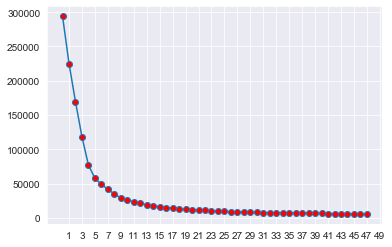

In [26]:
plt.plot(convergence_kmeans, marker='o', markerfacecolor='red')
plt.xticks(np.arange(1,50,2),rotation=0,size=10)

In [46]:
cluster = pye.coordinates.cluster_kmeans(Y_conc[:,0:2], k=500, max_iter=100)
dtrajs = cluster.dtrajs
cc_x = cluster.clustercenters[:,0]
cc_y = cluster.clustercenters[:,1]

In [61]:
lags = [1,10, 50, 100, 200, 300, 400, 500,1000,2000]
its = pye.msm.its(dtrajs, lags=lags, errors='bayes')

## cluster_kmeans.dtrajs

AttributeError: 'BayesianMSM' object has no attribute 'lagtimes'

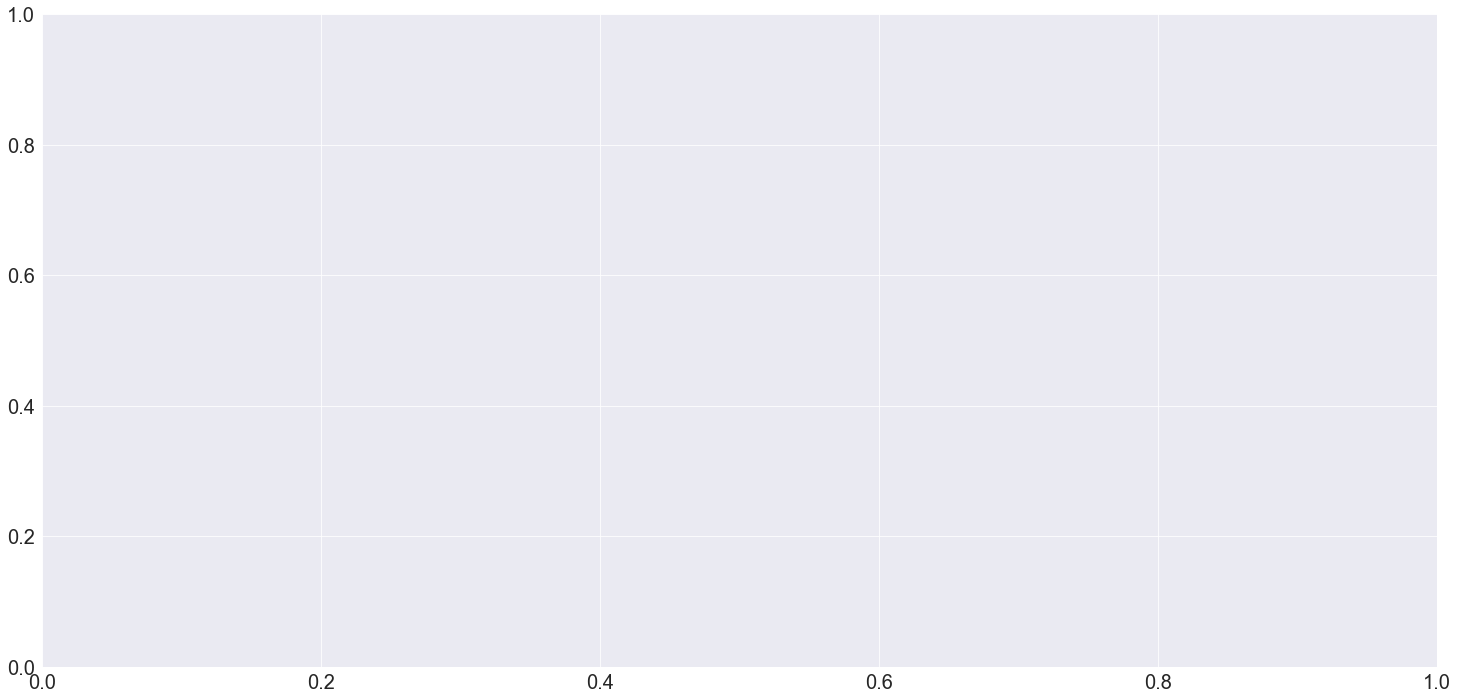

In [60]:
fig, axes = plt.subplots(figsize=(25,12))
pye.plots.plot_implied_timescales(its, marker='o', ms=15, lw=2, markerfacecolor=diverging_colors[5], nits=4 )

plt.xticks(size=20)
plt.xlabel('lagtime/step', size=25, weight='bold')
plt.yticks(size=20)
plt.ylabel('Timescale/steps', size=25, weight='bold')


## verifying the clustering

In [49]:
cluster_centers = 10
dtrajs = cluster.dtrajs
cc_x = cluster.clustercenters[:,0]
cc_y = cluster.clustercenters[:,1]

## MSM estimation

In [50]:
M = pye.msm.estimate_markov_model(dtrajs, 1000)

In [51]:
print('fraction of states used = {:f}'.format(M.active_state_fraction))
print('fraction of counts used = {:f}'.format(M.active_count_fraction))

fraction of states used = 1.000000
fraction of counts used = 1.000000


(-0.5, 25.5)

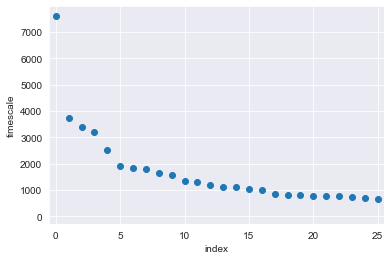

In [52]:
plt.plot(M.timescales(),linewidth=0,marker='o')
plt.xlabel('index')
plt.ylabel('timescale')
plt.xlim(-0.5,25.5)

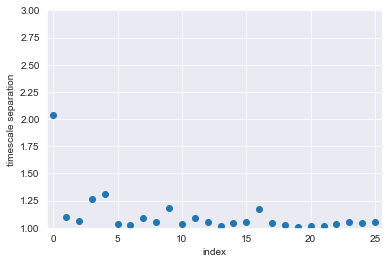

In [53]:
plt.plot(M.timescales()[:-1]/M.timescales()[1:], linewidth=0,marker='o')
plt.xlabel('index')
plt.ylabel('timescale separation')
plt.xlim(-0.5, 25.5)
plt.ylim(1, 3);


(<Figure size 720x720 with 4 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2678f828>,
       dtype=object))

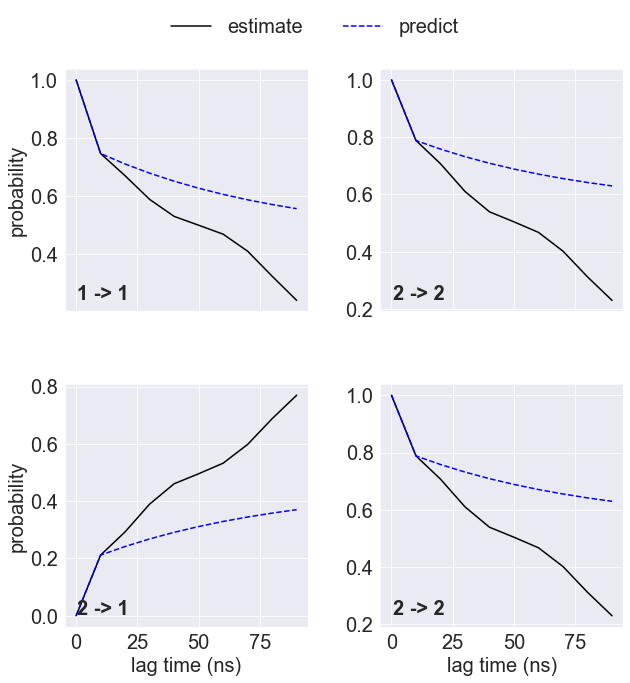

In [54]:
n_sets = 2
ck = M.cktest(n_sets, mlags=10, err_est=False, show_progress=True)

plt.rcParams.update({'font.size': 20})
pye.plots.plot_cktest(ck, diag=True, figsize=(10,10), layout=(n_sets, n_sets), padding_top=0.1, y01=False, padding_between=0.3, dt=0.01, units='ns')

#plt.save_figure('cktest.png')

(<Figure size 1080x1080 with 9 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a21f49f60>,
       dtype=object))

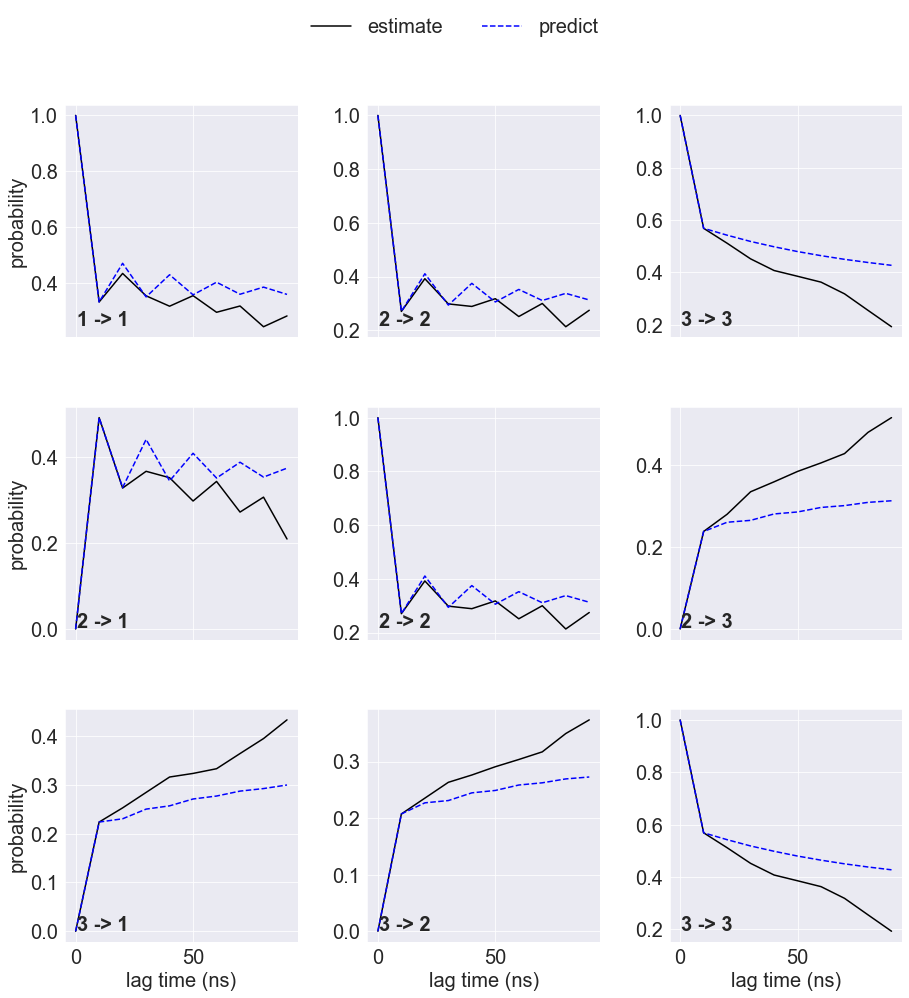

In [55]:
n_sets = 3
ck = M.cktest(n_sets, mlags=10, err_est=False, show_progress=True)

plt.rcParams.update({'font.size': 20})
pye.plots.plot_cktest(ck, diag=True, figsize=(15,15), layout=(n_sets, n_sets), padding_top=0.1, y01=False, padding_between=0.3, dt=0.01, units='ns')


In [328]:
for i, s in enumerate(M.metastable_sets):
    print('π_{} = {:f}'.format(i + 1, M.pi[s].sum()))

π_1 = 0.134960
π_2 = 0.153349
π_3 = 0.711692


In [329]:
metastable_traj = M.metastable_assignments[cluster_centers]
highest_membership = M.metastable_distributions.argmax(1)
coarse_state_centers = km.cluster_centers[M.active_set[highest_membership]]

IndexError: index 10 is out of bounds for axis 0 with size 9

In [330]:
hmm = M.coarse_grain(3)

In [331]:
np.set_printoptions(precision=4, suppress=True)
print(hmm.transition_matrix)

[[0.9675 0.0099 0.0226]
 [0.0142 0.9672 0.0186]
 [0.0108 0.0062 0.983 ]]


(<Figure size 720x503.277 with 1 Axes>, array([[0.    , 0.699 ],
        [0.4251, 0.    ],
        [1.    , 0.5419]]))

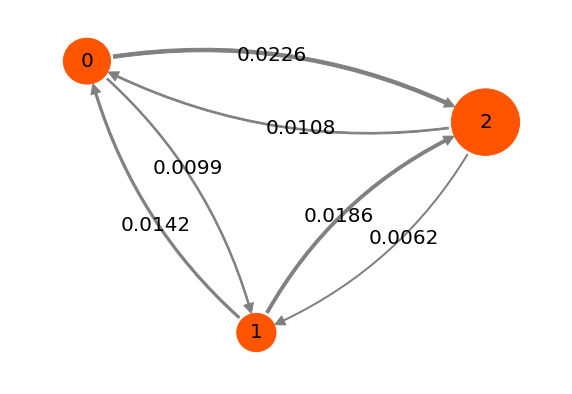

In [343]:
pye.plots.plot_markov_model(hmm, state_scale=0.5, arrow_scale=0.3, arrow_curvature=2.0, arrow_label_format='%0.4f',max_width=10, max_height=20)